## Pumpkin Pricing

Load up required libraries and dataset. Convert the data to a dataframe containing a subset of the data: 

- Only get pumpkins priced by the bushel
- Convert the date to a month
- Calculate the price to be an average of high and low prices
- Convert the price to reflect the pricing by bushel quantity

### import libraries and load dataframe

In [35]:
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
from sklearn.preprocessing import LabelEncoder
from sklearn.linear_model import LinearRegression
from sklearn.metrics import r2_score, mean_squared_error, mean_absolute_error
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import PolynomialFeatures
from sklearn.pipeline import make_pipeline

pumpkins = pd.read_csv('../data/US-pumpkins.csv')

pumpkins.head()


,City Name,Type,Package,Variety,Sub Variety,Grade,Date,Low Price,High Price,Mostly Low,...,Unit of Sale,Quality,Condition,Appearance,Storage,Crop,Repack,Trans Mode,Unnamed: 24,Unnamed: 25
0,BALTIMORE,NaN,24 inch bins,NaN,NaN,NaN,4/29/17,270.0,280.0,270.0,...,NaN,NaN,NaN,NaN,NaN,NaN,E,NaN,NaN,NaN
1,BALTIMORE,NaN,24 inch bins,NaN,NaN,NaN,5/6/17,270.0,280.0,270.0,...,NaN,NaN,NaN,NaN,NaN,NaN,E,NaN,NaN,NaN
2,BALTIMORE,NaN,24 inch bins,HOWDEN TYPE,NaN,NaN,9/24/16,160.0,160.0,160.0,...,NaN,NaN,NaN,NaN,NaN,NaN,N,NaN,NaN,NaN
3,BALTIMORE,NaN,24 inch bins,HOWDEN TYPE,NaN,NaN,9/24/16,160.0,160.0,160.0,...,NaN,NaN,NaN,NaN,NaN,NaN,N,NaN,NaN,NaN
4,BALTIMORE,NaN,24 inch bins,HOWDEN TYPE,NaN,NaN,11/5/16,90.0,100.0,90.0,...,NaN,NaN,NaN,NaN,NaN,NaN,N,NaN,NaN,NaN


### Preprocess Data

#### clean up df

In [36]:

pumpkins = pumpkins[pumpkins['Package'].str.contains('bushel', case=True, regex=True)]

new_columns = ['Package', 'Variety', 'City Name', 'Month', 'Low Price', 'High Price', 'Date', 'City Num', 'Variety Num']


pumpkins = pumpkins.drop([c for c in pumpkins.columns if c not in new_columns], axis=1)

price = (pumpkins['Low Price'] + pumpkins['High Price']) / 2

month = pd.DatetimeIndex(pumpkins['Date']).month


new_pumpkins = pd.DataFrame({'Month': month, 'Variety': pumpkins['Variety'], 'City': pumpkins['City Name'], 'Package': pumpkins['Package'], 'Low Price': pumpkins['Low Price'],'High Price': pumpkins['High Price'], 'Price': price})

new_pumpkins.loc[new_pumpkins['Package'].str.contains('1 1/9'), 'Price'] = price/1.1

new_pumpkins.loc[new_pumpkins['Package'].str.contains('1/2'), 'Price'] = price*2

new_pumpkins.head()


,Month,Variety,City,Package,Low Price,High Price,Price
70,9,PIE TYPE,BALTIMORE,1 1/9 bushel cartons,15.0,15.0,13.636364
71,9,PIE TYPE,BALTIMORE,1 1/9 bushel cartons,18.0,18.0,16.363636
72,10,PIE TYPE,BALTIMORE,1 1/9 bushel cartons,18.0,18.0,16.363636
73,10,PIE TYPE,BALTIMORE,1 1/9 bushel cartons,17.0,17.0,15.454545
74,10,PIE TYPE,BALTIMORE,1 1/9 bushel cartons,15.0,15.0,13.636364


#### prepare for regression

In [37]:
new_pumpkins.iloc[:, 0:-1] = new_pumpkins.iloc[:, 0:-1].apply(LabelEncoder().fit_transform)

new_pumpkins.head()

,Month,Variety,City,Package,Low Price,High Price,Price
70,1,3,1,0,5,3,13.636364
71,1,3,1,0,10,7,16.363636
72,2,3,1,0,10,7,16.363636
73,2,3,1,0,9,6,15.454545
74,2,3,1,0,5,3,13.636364


### Data Visualization

In [38]:
def scatter(x_label: str, y_label:str, dataset:pd.DataFrame):
    plt.scatter(x_label,y_label,data=dataset)
    plt.xlabel(x_label)
    plt.ylabel(y_label)

    print('correlation')
    print(new_pumpkins[x_label].corr(new_pumpkins[y_label]))

A basic scatterplot reminds us that we only have month data from August through December. We probably need more data to be able to draw conclusions in a linear fashion.

correlation
-0.14878293554077524


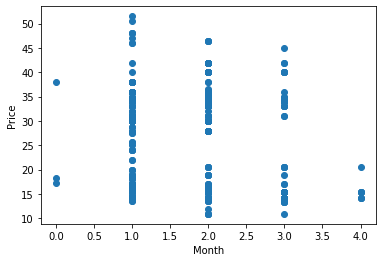

In [39]:
scatter('Month', 'Price', new_pumpkins)

City to Price scatterplot

correlation
0.3236397181608923


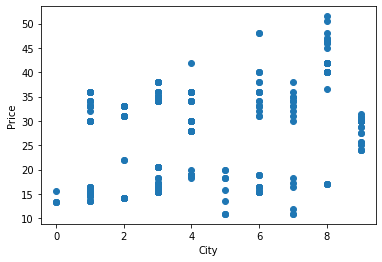

In [40]:
scatter('City', 'Price', new_pumpkins)

Package to Price scatterplot

correlation
0.6061712937226016


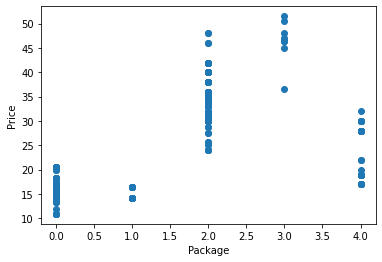

In [41]:
scatter('Package', 'Price', new_pumpkins)

### Linear Model

#### clean up data

In [42]:
new_pumpkins.dropna(inplace=True)
new_pumpkins.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 415 entries, 70 to 1742
Data columns (total 7 columns):
 #   Column      Non-Null Count  Dtype  
---  ------      --------------  -----  
 0   Month       415 non-null    int64  
 1   Variety     415 non-null    int64  
 2   City        415 non-null    int64  
 3   Package     415 non-null    int64  
 4   Low Price   415 non-null    int64  
 5   High Price  415 non-null    int64  
 6   Price       415 non-null    float64
dtypes: float64(1), int64(6)
memory usage: 25.9 KB


In [43]:
new_columns = ['Package', 'Price']
lin_pumpkins = new_pumpkins.drop([c for c in new_pumpkins.columns if c not in new_columns], axis='columns')

lin_pumpkins

,Package,Price
70,0,13.636364
71,0,16.363636
72,0,16.363636
73,0,15.454545
74,0,13.636364
...,...,...
1738,2,30.000000
1739,2,28.750000
1740,2,25.750000
1741,2,24.000000


#### build linear model

In [44]:
X = lin_pumpkins.values[:, :1]
y = lin_pumpkins.values[:, 1:2]

In [45]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=0)
lin_reg = LinearRegression()
lin_reg.fit(X_train, y_train)

pred = lin_reg.predict(X_test)

#### visualize linear Model

Model Accuracy:  0.3315342327998989


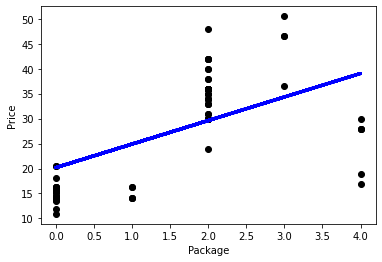

In [46]:
plt.scatter(X_test, y_test, color='black')
plt.plot(X_test, pred, color='blue', linewidth=3)

plt.xlabel('Package')
plt.ylabel('Price')

accuracy_score = lin_reg.score(X_train, y_train)
print('Model Accuracy: ', accuracy_score)

In [47]:
lin_reg.predict(np.array([ [2.75] ]))

array([[33.15655975]])

### Polynomial Model

#### clean up data

In [48]:
new_columns = ['Variety', 'Package', 'City', 'Month', 'Price']
poly_pumpkins = new_pumpkins.drop([c for c in new_pumpkins.columns if c not in new_columns], axis='columns')

poly_pumpkins

,Month,Variety,City,Package,Price
70,1,3,1,0,13.636364
71,1,3,1,0,16.363636
72,2,3,1,0,16.363636
73,2,3,1,0,15.454545
74,2,3,1,0,13.636364
...,...,...,...,...,...
1738,1,1,9,2,30.000000
1739,1,1,9,2,28.750000
1740,1,1,9,2,25.750000
1741,1,1,9,2,24.000000


#### visualize data

In [49]:
corr = poly_pumpkins.corr()
corr.style.background_gradient(cmap='coolwarm')

,Month,Variety,City,Package,Price
Month,1.000000,0.171330,-0.188728,-0.144847,-0.148783
Variety,0.171330,1.000000,-0.248441,-0.614855,-0.863479
City,-0.188728,-0.248441,1.000000,0.301604,0.323640
Package,-0.144847,-0.614855,0.301604,1.000000,0.606171
Price,-0.148783,-0.863479,0.323640,0.606171,1.000000


#### build polynomial Model

In [50]:
X = poly_pumpkins.iloc[:, 3:4].values
y = poly_pumpkins.iloc[:, 4:5].values

In [51]:
pipeline = make_pipeline(PolynomialFeatures(4), LinearRegression())

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=0)

pipeline.fit(np.array(X_train), y_train)

y_pred = pipeline.predict(X_test)

#### visualize polynomial Model

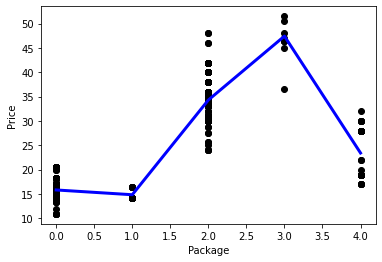

Model Accuracy:  0.8537946517073784


In [53]:
df = pd.DataFrame({'x': X_test[:, 0], 'y': y_pred[:, 0]})
df.sort_values(by='x', inplace=True)
points = pd.DataFrame(df).to_numpy()

plt.plot(points[:, 0], points[:, 1], color='blue', linewidth=3)
plt.xlabel('Package')
plt.ylabel('Price')
plt.scatter(X, y, color='black')
plt.show()

accuracy_score = pipeline.score(X_train, y_train)
print('Model Accuracy: ', accuracy_score)

In [54]:
pipeline.predict( np.array([ [2.75] ]))

array([[46.34509342]])